In [1]:
% matplotlib inline

import numpy as np, nibabel as nib
import utils.plotting_lighterbg as plot
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr
import pandas as pd
import statsmodels.formula.api as smf

sns.set_style('white')
sns.set_context('talk')

In [2]:
ddir = '/Users/sabine/data/macaque/resting'

#f_mdist = '%s/meandist/%s/maps_awake/lh.meandist.10k_fs_LR.nii.gz' % (ddir, monkey)
f_cort = '%s/MacaqueYerkes19.L.atlasroi.10k_fs_LR.shape.gii' % ddir
f_surf = '%s/%s.L.inflated.10k_fs_LR.surf.gii' % (ddir, 'Willow')
f_sulc = '%s/%s.L.sulc.10k_fs_LR.shape.gii' % (ddir, 'Willow')

In [3]:
cort = np.where(nib.load(f_cort).darrays[0].data==1)[0]
coords = nib.load(f_surf).darrays[0].data
faces = nib.load(f_surf).darrays[1].data
sulc = nib.load(f_sulc).darrays[0].data

## functional connectivity distance

In [4]:
# average across monkeys

mdist = np.zeros(coords.shape[0])

for monkey in ['Randi', 'Willow']:
    
    f_mdist = '%s/%s.lh.meandist.10k_fs_LR.nii.gz' % (ddir, monkey)
    mdist += nib.load(f_mdist).get_data().squeeze()
    
mdist = mdist / 2

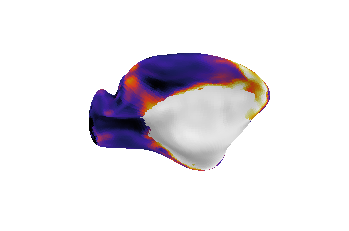

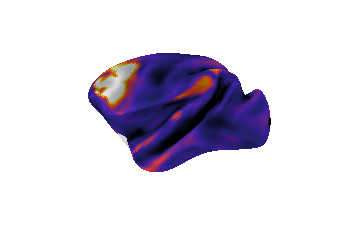

In [5]:
# avg
for azim in [0, 180]:
    img = plot.plot_surf_stat_map(coords, faces,
                                  mdist, mask=cort,
                                  bg_map=sulc,
                                  bg_on_stat=True,
                                  alpha=1,
                                  vmin=5,
                                  vmax=20,
                                  azim=azim,
                                  cmap='CMRmap')
    
    
    #plt.savefig('/nobackup/hunte1/sabine/tractdist/figures_ms/images/condist_%s' % (azim), dpi=300)

## distance from primary cortex

In [6]:
import gdist
from surfdist.utils import surf_keep_cortex, translate_src, recort

vertices, triangles = surf_keep_cortex((coords, faces), cort)

def dist_calc_fast(src, cortex, vertices, triangles, surf):
    src_new = translate_src(src, cortex)
    data = gdist.compute_gdist(vertices, triangles, source_indices=src_new)
    dist = recort(data, surf, cortex)
    del data
    return dist

In [7]:
# surf midthickness for dist calc
# maybe average distances for the two monkeys

# macaque surface for dist
f_surf_mid = '%s/Willow.L.midthickness.10k_fs_LR.surf.gii' % ddir
coords_mid = nib.load(f_surf_mid).darrays[0].data
faces_mid = nib.load(f_surf_mid).darrays[1].data
surf_mid = tuple((coords_mid, faces_mid))

In [8]:
f_atlas = '%s/L.MarkovCC12_M132_91-area.10k_fs_LR.label.gii' % ddir
atlas = nib.load(f_atlas)#.darrays[0].data

In [9]:
#atlas.labeltable.get_labels_as_dict()
prim_names = ['V1', 'CORE', 'F1', '3']#, 'Gu', 'PIRIFORM']
prim_keys = [83, 36, 39, 3]#, 47, 64]

In [10]:
prim_dist = np.empty((len(prim_keys), 
                     coords.shape[0]))

for n, key in enumerate(prim_keys):
    
    prim_dist[n] = dist_calc_fast(np.where(atlas.darrays[0].data==key)[0], 
                                  cort, vertices, triangles, surf_mid)
    
prim_dist = np.min(prim_dist, axis=0)

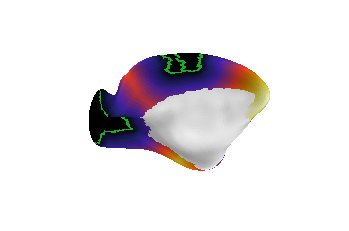

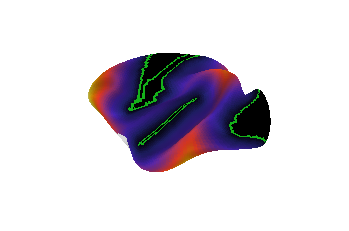

In [11]:
labels_prim = [np.where(atlas.darrays[0].data==key)[0] for key in prim_keys]

for azim in [0, 180]:
    img = plot.plot_surf_stat_map(coords, faces,
                                  prim_dist, mask=cort,
                                  labels = labels_prim, 
                                  azim=azim,
                                  bg_map=sulc, bg_on_stat=True, 
                                  cmap='CMRmap')
    
    #plt.savefig('/nobackup/hunte1/sabine/tractdist/figures_ms/images/primdist_%s' % (azim), dpi=300)

In [12]:
print prim_dist.min(), prim_dist.max()

0.0 30.734746335528918


excluding anteriormost PFC areas that have highest possible distance from primary (more than elsewhere in cortex)

In [13]:
annot = np.array([atlas.labeltable.get_labels_as_dict()[key] for key in atlas.darrays[0].data])

df = pd.DataFrame({'area': annot, 
                   'meandist': mdist, 
                   'primdist': prim_dist})

df['area'] = df['area'].astype(str).values

print df.shape
df.head()

(10242, 3)


,area,meandist,primdist
0,23,8.088145,7.271953
1,V6A,8.678762,7.265151
2,2,7.436706,2.262008
3,F1,7.752873,0.000000
4,V1,8.657006,0.000000


In [14]:
df_area = df.groupby('area').mean().reset_index()

order = df_area.sort_values('primdist').index
order = [str(area) for area in order]

df_area.sort_values('primdist', ascending=False).head(15)

,area,meandist,primdist
16,32,17.478175,28.267347
1,10,10.242113,27.641260
5,14,13.059496,26.849069
12,25,17.113664,26.684684
10,24c,17.587154,25.207043
2,11,7.838133,24.529078
56,OPAI,12.502702,24.403512
31,9,12.763238,23.180494
4,13,7.813853,22.088094
21,46v,12.509761,21.629844


In [15]:
excl_areas = list(df_area[df_area.primdist>20].area)
excl_areas

['10', '11', '13', '14', '24c', '25', '32', '46d', '46v', '9', 'F6', 'OPAI']

In [16]:
# for finding keys: atlas.labeltable.get_labels_as_dict()
excl_keys = [6, 7, 9, 10, 18, 12, 14, 23, 24, 5, 44, 56]

## Relationship of functional connectivity distance with distance from primary cortex

### exclude anteriormost PFC due to deviating patterns and also the primary regions themselves

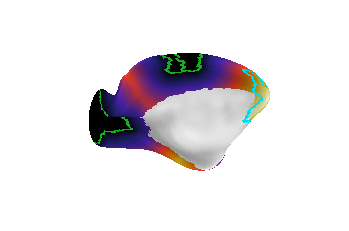

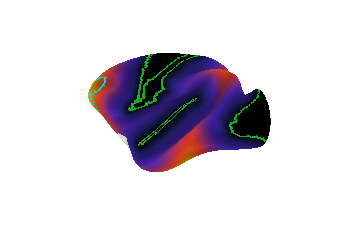

In [82]:
labels_excl_area = [np.where(atlas.darrays[0].data==key)[0] for key in excl_keys]

label_excl_areas = list()

for l in labels_excl_area:
    label_excl_areas += list(l)
    
label_excl_areas = np.array(label_excl_areas)


labels_prim = [np.where(atlas.darrays[0].data==key)[0] for key in prim_keys]

#labels = labels_prim + label_excl_area
labels_prim.append(label_excl_areas)

for azim in [0, 180]:
    img = plot.plot_surf_stat_map(coords, faces,
                                  prim_dist, mask=cort,
                                  labels = labels_prim,#label_excl_area,
                                  label_cpal = ["green", "green", "green", "green", "aqua blue"],
                                  azim=azim,
                                  sulc=sulc, bg_map=sulc, 
                                  bg_on_stat=True, cmap='CMRmap')
    
    plt.savefig('/Users/sabine/Downloads/gdist_from_prim_%s' % (azim), dpi=300)

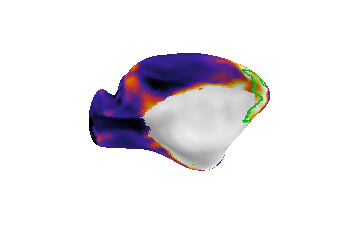

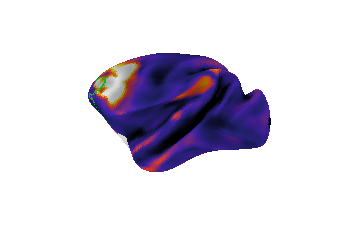

In [20]:
labels_excl_area = [np.where(atlas.darrays[0].data==key)[0] for key in excl_keys]

label_excl_areas = list()

for l in labels_excl_area:
    label_excl_areas += list(l)
    
label_excl_areas = [np.array(label_excl_areas),]


for azim in [0, 180]:
    img = plot.plot_surf_stat_map(coords, faces,
                                  mdist, mask=cort,
                                  labels = label_excl_areas, 
                                  azim=azim,
                                  vmin=5,
                                  vmax=20,
                                  sulc=sulc,
                                  bg_map=sulc, bg_on_stat=True, cmap='CMRmap')

## Relationship between distance from primary and connectivity distance

In [24]:
# on the surface
mdist_parcels = np.array([df_area.meandist[df_area.area==node].iloc[0] for node in annot])
primdist_parcels = np.array([df_area.primdist[df_area.area==node].iloc[0] for node in annot])

In [25]:
reg_filtr_1 = ((~df_area.area.isin(excl_areas)) &
               (df_area.area != '???'))

## stats

In [27]:
# intial model assessing outliers
model = smf.ols(formula='meandist ~ primdist', data=df_area[reg_filtr_1]).fit()
print model.summary()

                            OLS Regression Results                            
Dep. Variable:               meandist   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     15.14
Date:                Thu, 30 Aug 2018   Prob (F-statistic):           0.000211
Time:                        22:46:49   Log-Likelihood:                -230.59
No. Observations:                  79   AIC:                             465.2
Df Residuals:                      77   BIC:                             469.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.6471      1.038      6.403      0.0

In [28]:
df_area['func_resid'] = 999
df_area['func_resid'][reg_filtr_1] = model.resid

df_area['func_stud_resid'] = 999
df_area['func_stud_resid'][reg_filtr_1] = model.outlier_test()['student_resid']

df_area['func_unadj_p'] = 999
df_area['func_unadj_p'][reg_filtr_1] = model.outlier_test()['unadj_p']

df_area['func_bonf_p'] = 999
df_area['func_bonf_p'][reg_filtr_1] = model.outlier_test()['bonf(p)']

/Users/sabine/anaconda2/envs/distconnect/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/sabine/anaconda2/envs/distconnect/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/sabine/anaconda2/envs/distconnect/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/sabine/anaconda2/envs/distconnect/lib/python2.7/site-pack

In [29]:
df_area[reg_filtr_1].sort_values('func_stud_resid').head()

,area,meandist,primdist,func_resid,func_stud_resid,func_unadj_p,func_bonf_p
80,TEpv,8.223825,17.663362,-5.573877,-1.268246,0.208581,1.0
91,VIP,5.209786,10.277500,-5.597905,-1.246493,0.216412,1.0
3,12,7.351674,15.395721,-5.528021,-1.245084,0.216926,1.0
53,MIP,5.894581,11.923208,-5.579340,-1.244969,0.216968,1.0
74,TEOm,6.353906,12.225335,-5.242325,-1.169025,0.246047,1.0


In [30]:
df_area[reg_filtr_1].sort_values('func_stud_resid').tail()

,area,meandist,primdist,func_resid,func_stud_resid,func_unadj_p,func_bonf_p
71,SUBICULUM,21.514451,16.464733,8.201989,1.878725,6.411674e-02,1.000000
29,8m,21.782900,8.927106,11.521887,2.653018,9.708638e-03,0.766982
19,45B,22.412930,10.470833,11.526972,2.656715,9.611935e-03,0.759343
30,8r,23.544647,13.320698,11.504981,2.665419,9.387718e-03,0.741630
28,8l,32.749574,10.557328,21.828601,5.772319,1.609096e-07,0.000013


In [31]:
df_area[reg_filtr_1].to_pickle('./data/df_revrequest2_outlcomp_glm1.pkl')

=> with a studentized residual of 5.7, area 8l is a striking outlier and will be excluded

In [32]:
reg_filtr_2 = ((~df_area.area.isin(excl_areas)) &
               (df_area.area != '???') &
               (df_area.area!='8l')) # outlier (based on residual)

In [34]:
model = smf.ols(formula='meandist ~ primdist', data=df_area[reg_filtr_2]).fit()
print model.summary()

                            OLS Regression Results                            
Dep. Variable:               meandist   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     19.20
Date:                Thu, 30 Aug 2018   Prob (F-statistic):           3.72e-05
Time:                        22:48:11   Log-Likelihood:                -213.99
No. Observations:                  78   AIC:                             432.0
Df Residuals:                      76   BIC:                             436.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.5559      0.871      7.523      0.0

In [84]:
model.pvalues

Intercept    8.951579e-11
primdist     3.717766e-05
dtype: float64

In [35]:
df_area['func_resid'] = 999
df_area['func_resid'][reg_filtr_2] = model.resid

df_area['func_stud_resid'] = 999
df_area['func_stud_resid'][reg_filtr_2] = model.outlier_test()['student_resid']

df_area['func_unadj_p'] = 999
df_area['func_unadj_p'][reg_filtr_2] = model.outlier_test()['unadj_p']

df_area['func_bonf_p'] = 999
df_area['func_bonf_p'][reg_filtr_2] = model.outlier_test()['bonf(p)']

/Users/sabine/anaconda2/envs/distconnect/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/sabine/anaconda2/envs/distconnect/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/sabine/anaconda2/envs/distconnect/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/sabine/anaconda2/envs/distconnect/lib/python2.7/site-pack

In [36]:
df_area[reg_filtr_2].sort_values('func_stud_resid').head()

,area,meandist,primdist,func_resid,func_stud_resid,func_unadj_p,func_bonf_p
91,VIP,5.209786,10.277500,-5.282859,-1.405716,0.163938,1.0
53,MIP,5.894581,11.923208,-5.228443,-1.393929,0.167456,1.0
80,TEpv,8.223825,17.663362,-5.097932,-1.385329,0.170058,1.0
3,12,7.351674,15.395721,-5.101475,-1.372388,0.174033,1.0
46,FST,5.287852,9.503651,-4.908375,-1.303046,0.196545,1.0


In [37]:
df_area[reg_filtr_2].sort_values('func_stud_resid').tail()

,area,meandist,primdist,func_resid,func_stud_resid,func_unadj_p,func_bonf_p
17,44,16.952744,7.977243,7.341200,1.976640,0.051759,1.000000
71,SUBICULUM,21.514451,16.464733,8.651822,2.395313,0.019102,1.000000
29,8m,21.782900,8.927106,11.807515,3.318970,0.001396,0.108922
19,45B,22.412930,10.470833,11.846230,3.334730,0.001329,0.103691
30,8r,23.544647,13.320698,11.886322,3.366810,0.001202,0.093766


In [38]:
# there are some areas with residuals > 3 but this is the second round so we keep them, otherwise endless...

In [39]:
df_area[reg_filtr_2].to_pickle('./data/df_revrequest2_outlcomp_glm2.pkl')

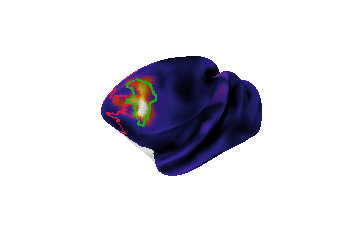

In [73]:
# zoom into PFC


# anteriormost excluded PFC areas
labels_excl_area = [np.where(atlas.darrays[0].data==key)[0] for key in excl_keys]

label_excl_areas = list()

for l in labels_excl_area:
    label_excl_areas += list(l)
    
label_excl_areas = np.array(label_excl_areas)



# PFC peak areas
labels_peak_areas = [np.where(atlas.darrays[0].data==key)[0] for key in [22, 30, 31, 32]] 

label_peak_areas = list()

for l in labels_peak_areas:
    label_peak_areas += list(l)
    
label_peak_areas = [np.array(label_peak_areas),]




img = plot.plot_surf_stat_map(coords, faces,
                              mdist, mask=cort,
                              labels = [label_excl_areas]+label_peak_areas,
                              label_cpal = ['lipstick', 'green'],#"clear blue"],
                              azim=145,
                              elev=25,
                              vmin=5,
                              vmax=35,
                              sulc=sulc,
                              bg_map=sulc, bg_on_stat=True, cmap='CMRmap')

plt.savefig('/Users/sabine/Downloads/gdist_from_prim_pfc', dpi=300)

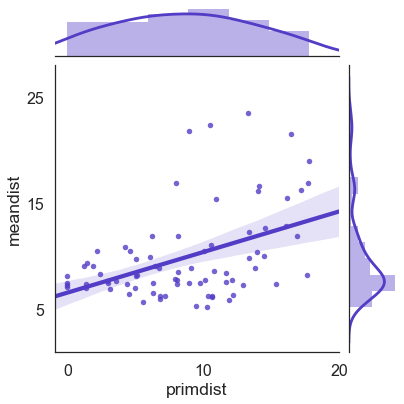

In [80]:
g = sns.jointplot(x="primdist", 
                  y="meandist", 
                  data=df_area[reg_filtr_2], 
                  kind='reg', 
                  color="#533cc6", 
                  xlim=(-.9,20), 
                  ylim=(1,28),
                  stat_func=None,
                  scatter_kws={"s": 30})


_ = plt.xticks([0,10,20])
_ = plt.yticks([5,15,25])

g.savefig('/Users/sabine/Downloads/relationship_func.png', dpi=300)

/Users/sabine/anaconda2/envs/distconnect/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


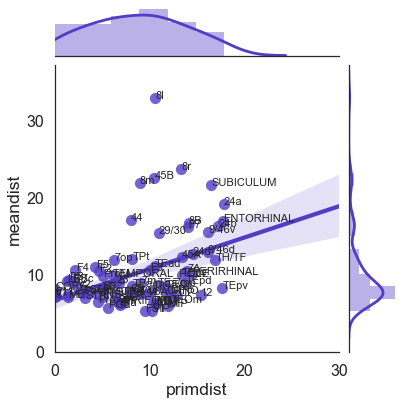

In [26]:
# too crowded

sns.set_context('poster')

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']), size='xx-small')



g = sns.jointplot(x="primdist", 
                  y="meandist", 
                  data=df_area[reg_filtr_1], # or reg_filtr_2
                  kind='reg', 
                  color="#533cc6", 
                  xlim=(0,30), 
                  ylim=(0,37),
                  stat_func=None)


_ = plt.xticks([0,10,20,30])
_ = plt.yticks([0,10,20,30])

label_point(df_area.primdist[reg_filtr_1], 
            df_area.meandist[reg_filtr_1], 
            df_area.area[reg_filtr_1], 
            plt.gca()) 

#g.savefig('/nobackup/hunte1/sabine/tractdist/figures_ms/images/relationship_func_mask.png', dpi=300)

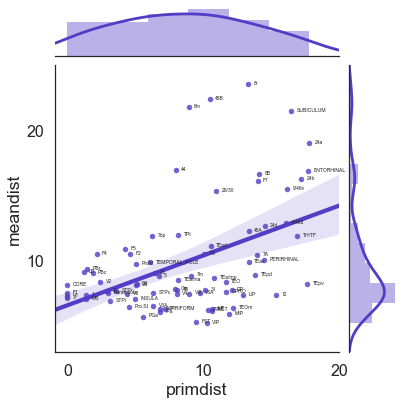

In [71]:
sns.set_context('poster')

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.4, point['y'], str(point['val']), size=5)



g = sns.jointplot(x="primdist", 
                  y="meandist", 
                  data=df_area[reg_filtr_2], 
                  kind='reg', 
                  color="#533cc6", 
                  xlim=(-.9,20), 
                  ylim=(3,25),
                  stat_func=None,
                  scatter_kws={"s": 30})


_ = plt.xticks([0,10,20])
_ = plt.yticks([10,20])

label_point(df_area.primdist[reg_filtr_2], 
            df_area.meandist[reg_filtr_2], 
            df_area.area[reg_filtr_2], 
            plt.gca()) 
